In the scenario where you don't have any gradients to learn from, e.g. a square wave as opposed to a gaussian peak.

goal: to characterize the shape of the square wave

Running adaptive learner to 250 points using an iterator pattern...
Iteration 20: Evaluated 20/250 points. Current loss: 0.0167
Iteration 40: Evaluated 40/250 points. Current loss: 0.0068
Iteration 60: Evaluated 60/250 points. Current loss: 0.2379
Iteration 80: Evaluated 80/250 points. Current loss: 0.1022
Iteration 100: Evaluated 100/250 points. Current loss: 0.1059
Iteration 120: Evaluated 120/250 points. Current loss: 0.0968
Iteration 140: Evaluated 140/250 points. Current loss: 0.0531
Iteration 160: Evaluated 160/250 points. Current loss: 0.0544
Iteration 180: Evaluated 180/250 points. Current loss: 0.0504
Iteration 200: Evaluated 200/250 points. Current loss: 0.0313
Iteration 220: Evaluated 220/250 points. Current loss: 0.0373
Iteration 240: Evaluated 240/250 points. Current loss: 0.0314
Adaptive learning complete in 250 iterations (0.09 seconds).
Total points evaluated: 250
Intersection over Union (IoU) for boundary: 0.9180


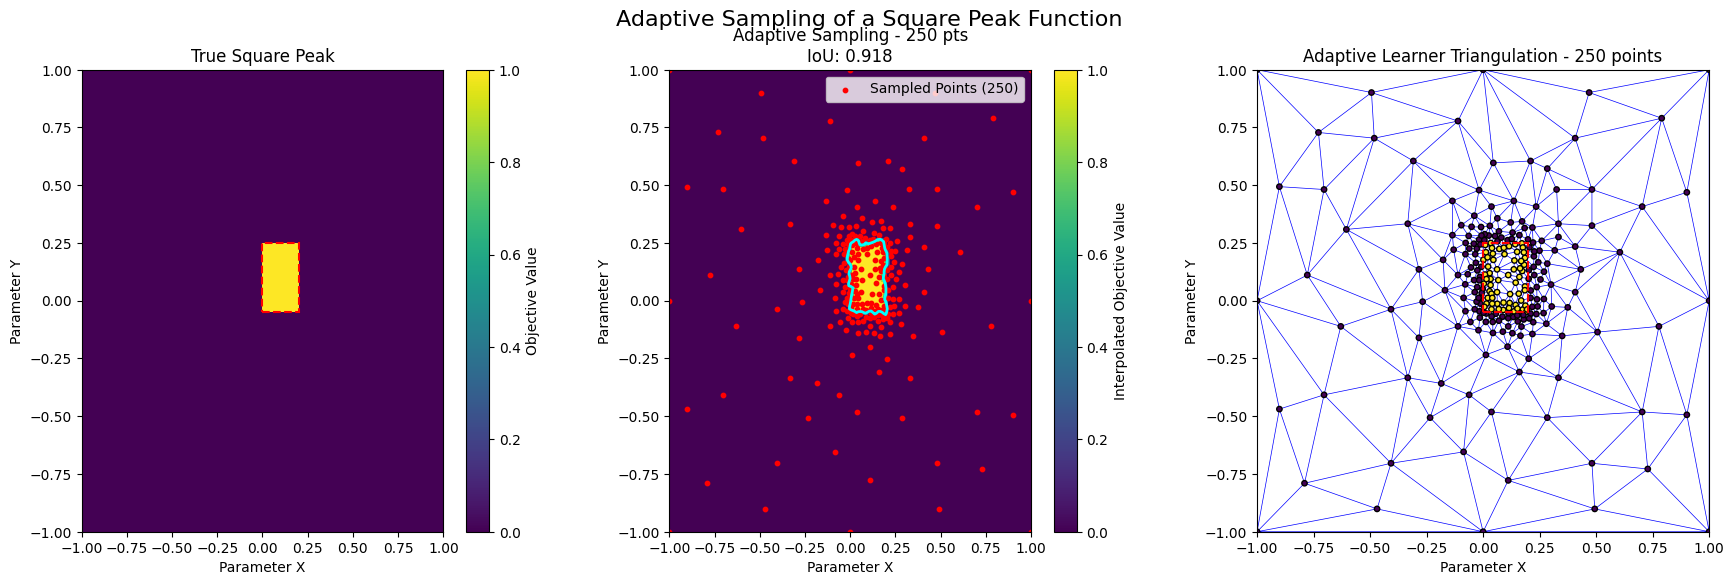

In [14]:
import adaptive
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from functools import partial
import time

# Define the geometry and values for a "square peak" function.
# This function will be high inside a defined square and low elsewhere.
SQUARE_CENTER_X = 0.1
SQUARE_CENTER_Y = 0.1
SQUARE_WIDTH = 0.2
SQUARE_HEIGHT = 0.3

# Calculate the boundaries of the square peak based on its center and dimensions.
X_MIN = SQUARE_CENTER_X - SQUARE_WIDTH / 2
X_MAX = SQUARE_CENTER_X + SQUARE_WIDTH / 2
Y_MIN = SQUARE_CENTER_Y - SQUARE_HEIGHT / 2
Y_MAX = SQUARE_CENTER_Y + SQUARE_HEIGHT / 2

# Define the high and low values of the objective function.
HIGH_VALUE = 1.0
LOW_VALUE = 0.0
# The contour level is the midpoint, useful for identifying the boundary.
CONTOUR_LEVEL = (HIGH_VALUE + LOW_VALUE) / 2

# Define the parameter space bounds for the adaptive learner.
PARAMETER_BOUNDS = [(-1.0, 1.0), (-1.0, 1.0)]

def square_peak_objective(xy_tuple):
    """
    Objective function that defines a square peak.
    Returns HIGH_VALUE if the point (x, y) is within the defined square,
    otherwise returns LOW_VALUE.
    """
    x, y = xy_tuple
    if X_MIN <= x <= X_MAX and Y_MIN <= y <= Y_MAX:
        return HIGH_VALUE
    else:
        return LOW_VALUE

# Prepare a figure with three subplots for visualization.
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

def plot_true_square_peak(ax, title="True Square Peak"):
    """
    Helper function to visualize the actual square peak.
    It creates a grid and evaluates the objective function at each point.
    """
    # Generate a dense grid of points for an accurate representation.
    x_coords = np.linspace(PARAMETER_BOUNDS[0][0], PARAMETER_BOUNDS[0][1], 200)
    y_coords = np.linspace(PARAMETER_BOUNDS[1][0], PARAMETER_BOUNDS[1][1], 200)
    X, Y = np.meshgrid(x_coords, y_coords)
    # Evaluate the objective function for each point in the grid.
    Z = np.array([square_peak_objective((x, y)) for x, y in zip(X.ravel(), Y.ravel())]).reshape(X.shape)

    # Plot the true function as a color mesh.
    c = ax.pcolormesh(X, Y, Z, cmap='viridis', shading='auto', vmin=LOW_VALUE, vmax=HIGH_VALUE)
    fig.colorbar(c, ax=ax, label="Objective Value")
    ax.set_xlabel("Parameter X")
    ax.set_ylabel("Parameter Y")
    ax.set_title(title)
    # Draw a rectangle indicating the actual boundary of the square peak.
    rect = plt.Rectangle((X_MIN, Y_MIN), SQUARE_WIDTH, SQUARE_HEIGHT,
                         linewidth=1.5, edgecolor='r', facecolor='none', linestyle='--')
    ax.add_patch(rect)
    ax.set_xlim(PARAMETER_BOUNDS[0])
    ax.set_ylim(PARAMETER_BOUNDS[1])


# Initialize the adaptive learner for a 2D function with the specified bounds.
learner = adaptive.Learner2D(square_peak_objective, bounds=PARAMETER_BOUNDS)
N_POINTS_GOAL = 250 # Target number of points to evaluate.
POINTS_PER_ITERATION = 1 # How many points the learner suggests at each step.

print(f"Running adaptive learner to {N_POINTS_GOAL} points using an iterator pattern...")
evaluated_points_count = 0
iteration_count = 0
start_time = time.time() # Record start time for performance measurement.

# Main loop for adaptive sampling.
# The learner suggests points, we evaluate them, and tell the learner the results.
while evaluated_points_count < N_POINTS_GOAL:
    # Ask the learner for the next set of points to sample.
    # 'tell_pending=True' informs the learner these points are being processed.
    suggested_points, _ = learner.ask(POINTS_PER_ITERATION, tell_pending=True)

    if not suggested_points: # Check if the learner has any more points to suggest.
        print("Learner has no more points to suggest. Stopping.")
        break

    # Evaluate the objective function for each suggested point.
    for point in suggested_points:
        value = square_peak_objective(point)
        learner.tell(point, value) # Provide the (point, value) pair to the learner.
        evaluated_points_count += 1
        if evaluated_points_count >= N_POINTS_GOAL: # Stop if goal is reached.
            break
    iteration_count += 1
    # Periodically print progress.
    if iteration_count % 20 == 0:
        print(f"Iteration {iteration_count}: Evaluated {evaluated_points_count}/{N_POINTS_GOAL} points. Current loss: {learner.loss():.4f}")

end_time = time.time() # Record end time.
print(f"Adaptive learning complete in {iteration_count} iterations ({end_time - start_time:.2f} seconds).")
print(f"Total points evaluated: {learner.npoints}")


# Adjust subplot spacing to prevent titles/labels from overlapping.
plt.subplots_adjust(wspace=0.3)
# Plot the ground truth in the first subplot.
plot_true_square_peak(axes[0])

# Retrieve the data collected by the learner.
sampled_points = np.array(list(learner.data.keys()))
sampled_values = np.array(list(learner.data.values()))

# Define resolution for the interpolation grid and IoU calculation.
grid_res = 200
grid_x_coords = np.linspace(PARAMETER_BOUNDS[0][0], PARAMETER_BOUNDS[0][1], grid_res)
grid_y_coords = np.linspace(PARAMETER_BOUNDS[1][0], PARAMETER_BOUNDS[1][1], grid_res)
Grid_X, Grid_Y = np.meshgrid(grid_x_coords, grid_y_coords) # Create the interpolation grid.

iou_score = 0.0
# Interpolation requires at least 4 points for 'linear' method with griddata
# and for a meaningful triangulation.
if len(learner.data) >= 4:
    # Interpolate the sampled data onto the grid.
    interpolated_Z = griddata(sampled_points, sampled_values, (Grid_X, Grid_Y), method='linear')
    # Fill NaN values (points outside the convex hull of samples) for plotting.
    interpolated_Z_filled = np.nan_to_num(interpolated_Z, nan=LOW_VALUE)

    # Evaluate boundary accuracy using Intersection over Union (IoU).
    # Create a boolean mask for the true peak area.
    true_mask = np.zeros_like(Grid_X, dtype=bool)
    true_mask[(Grid_X >= X_MIN) & (Grid_X <= X_MAX) & (Grid_Y >= Y_MIN) & (Grid_Y <= Y_MAX)] = True

    # Create a boolean mask for the learned peak area based on the contour level.
    # NaNs from griddata (outside convex hull) are treated as outside the peak.
    learned_mask = np.zeros_like(Grid_X, dtype=bool)
    learned_mask[~np.isnan(interpolated_Z) & (interpolated_Z > CONTOUR_LEVEL)] = True

    # Calculate IoU.
    intersection = np.sum(true_mask & learned_mask)
    union = np.sum(true_mask | learned_mask)
    iou_score = intersection / union if union > 0 else 0 # Avoid division by zero.
    print(f"Intersection over Union (IoU) for boundary: {iou_score:.4f}")

else:
    print("Not enough data points for interpolation or IoU calculation.")
    # If not enough points, create a low-value surface for consistent plotting.
    interpolated_Z_filled = np.full_like(Grid_X, LOW_VALUE)


# Second plot: Adaptive sampling points and the interpolated surface.
c_adaptive = axes[1].pcolormesh(Grid_X, Grid_Y, interpolated_Z_filled, cmap='viridis', shading='auto', vmin=LOW_VALUE, vmax=HIGH_VALUE)
fig.colorbar(c_adaptive, ax=axes[1], label="Interpolated Objective Value")
axes[1].scatter(sampled_points[:, 0], sampled_points[:, 1], c='red', s=10, label=f'Sampled Points ({learner.npoints})')

if len(learner.data) >= 4:
    # Plot the learned boundary contour if enough data exists.
    axes[1].contour(Grid_X, Grid_Y, interpolated_Z_filled, levels=[CONTOUR_LEVEL], colors='cyan', linewidths=2, linestyles='solid')

axes[1].set_xlabel("Parameter X")
axes[1].set_ylabel("Parameter Y")
axes[1].set_title(f"Adaptive Sampling - {learner.npoints} pts\nIoU: {iou_score:.3f}")
# Overlay the true boundary for comparison.
rect_adaptive = plt.Rectangle((X_MIN, Y_MIN), SQUARE_WIDTH, SQUARE_HEIGHT,
                              linewidth=1.5, edgecolor='r', facecolor='none', linestyle='--')
axes[1].add_patch(rect_adaptive)
axes[1].legend(loc="upper right")
axes[1].set_xlim(PARAMETER_BOUNDS[0])
axes[1].set_ylim(PARAMETER_BOUNDS[1])


# Third plot: The learner's internal triangulation of the sampled points.
if len(learner.data) >= 4: # Triangulation needs at least 3 non-collinear points.
    ip = learner.interpolator(scaled=False) # Get the learner's interpolator object.
    if ip.tri.simplices.size > 0: # Check if a valid triangulation exists.
        axes[2].triplot(ip.tri.points[:, 0], ip.tri.points[:, 1], ip.tri.simplices, lw=0.5, color='blue')
        # Scatter plot of sampled points, colored by their value.
        axes[2].scatter(sampled_points[:, 0], sampled_points[:, 1], c=sampled_values, s=15, cmap='viridis', edgecolor='k', vmin=LOW_VALUE, vmax=HIGH_VALUE)
    else: # If no simplices, just plot the points.
        axes[2].scatter(sampled_points[:, 0], sampled_points[:, 1], c=sampled_values, s=15, cmap='viridis', edgecolor='k', vmin=LOW_VALUE, vmax=HIGH_VALUE)
else: # If too few points for triangulation, just show the sampled points.
     axes[2].scatter(sampled_points[:, 0], sampled_points[:, 1], c='red', s=10)

axes[2].set_xlabel("Parameter X")
axes[2].set_ylabel("Parameter Y")
axes[2].set_title(f"Adaptive Learner Triangulation - {learner.npoints} points")
# Overlay the true boundary for comparison.
rect_tri = plt.Rectangle((X_MIN, Y_MIN), SQUARE_WIDTH, SQUARE_HEIGHT,
                          linewidth=1.5, edgecolor='r', facecolor='none', linestyle='--')
axes[2].add_patch(rect_tri)
axes[2].set_xlim(PARAMETER_BOUNDS[0])
axes[2].set_ylim(PARAMETER_BOUNDS[1])

# Add a super title to the entire figure.
plt.suptitle("Adaptive Sampling of a Square Peak Function", fontsize=16)
# Save the figure to a file.
plt.savefig("adaptive_square_peak_iterator_demo_with_boundary.png", dpi=150)
# Display the plots.
plt.show()